Dataset: https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset MotionSense Dataset : Smartphone Sensor Data - HAR

Este dataset contiene series de datos temporales de acelerómetros y giróscopos de un Iphone 6, de un total de 24 personas diferentes, realizando 6 tipos de ejercicios diferentes, en 15 pruebas.
Etiquetas (actividades): dws: downstairs ups: upstairs sit: sitting std: standing wlk: walking jog: jogging

Los datos vienen por un lado en un fichero data_subjects_info.csv, con la siguiente información de cada persona:
code,weight,height,age,gender

Y por otro lado, en una carpeta 'A_DeviceMotion_data'. Dentro de esta carpeta, hay a su vez 15 carpetas, una por prueba.
Cada subcarpeta, está nombrada con 3 letras (la acividad, y guión bajo y un número)
Dentro de estas carpetas encontramos las grabaciones de cada individuo, con las series de datos temporales. Por ejemplo:
sub_1.csv:
,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z

Vamos a tratar de identificar el tipo de actividad primero analizando todos los datos juntos, y después, trataremos de sacar métricas de cada grabación, y clasificar en base a estas métricas.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV

class DataPipeline:
    def __init__(self, data_dir, subject_data_file, predictors, target):
        self.data_dir = data_dir
        self.subject_data_file = subject_data_file
        self.predictors = predictors
        self.target = target
        self.scaler = StandardScaler()
                # Selecciona el clasificador según el parámetro proporcionado


    #funciones auxiliares para importar los datos
    def get_all_dataset_paths(self, input_dir):
        input_files = []
        for dirs, subdirs, files in os.walk(input_dir):
            for file in files:
                if file.endswith('.csv'):
                    input_files.append(os.path.join(dirs, file))
        return input_files

    def load_whole_dataframe_from_paths(self, paths, meta):
        df = pd.DataFrame()
        for p in paths:
            c_dir, c_file = p.split('\\')[-2], p.split('\\')[-1]
            c_cat, c_ses = c_dir.split('_')[-2], c_dir.split('_')[-1]
            c_sub = c_file.split('_')[-1].split('.')[-2]
            tdf = pd.read_csv(p, encoding="utf-8")
            new_columns = pd.DataFrame({
                'subject_id': int(c_sub),
                'session_id': int(c_ses),
                'category': str(c_cat),
                'age': int(meta.age[int(c_sub) - 1]),
                'gender': int(meta.gender[int(c_sub) - 1]),
                'height': int(meta.height[int(c_sub) - 1]),
                'weight': int(meta.weight[int(c_sub) - 1])
            }, index=tdf.index)
            tdf = pd.concat([new_columns, tdf], axis=1)
            df = pd.concat([df, tdf])
        df.reset_index(drop=True, inplace=True)
        return df

    #función de preprocesado. Llama a las funciones auxiliares y genera un dataframe con los datos a entrenar.
    def preprocess(self, summary=False):
        self.summary = summary
        subject_data_frame = pd.DataFrame(pd.read_csv(self.subject_data_file, encoding="utf-8"))
        all_dataset_paths = self.get_all_dataset_paths(self.data_dir)
        data = self.load_whole_dataframe_from_paths(all_dataset_paths, subject_data_frame)
        data.drop('Unnamed: 0', axis=1, inplace=True)

        #si summary = True, extraemos features decada grabación en lugar de analizar todos los datos de la misma. Computacionalmente será más eficiente, y en caso de que las grabacioens
        #tuvieran datos en reposo, al obtener una media no analizaríamos individualmente esos datos.
        if self.summary:
            data['acceleration_magnitude'] = np.sqrt(data['userAcceleration.x']**2 + data['userAcceleration.y']**2 + data['userAcceleration.z']**2)
            # Calcula las métricas resumen para cada archivo de grabación
            summary_data = data.groupby(['subject_id', 'session_id']).agg(
                category=('category', 'first'),
                age=('age', 'first'),
                gender=('gender', 'first'),
                height=('height', 'first'),
                weight=('weight', 'first'),
                attitude_roll_mean=('attitude.roll', 'mean'),
                attitude_roll_std=('attitude.roll', 'std'),
                attitude_pitch_mean=('attitude.pitch', 'mean'),
                attitude_pitch_std=('attitude.pitch', 'std'),
                attitude_yaw_mean=('attitude.yaw', 'mean'),
                attitude_yaw_std=('attitude.yaw', 'std'),
                gravity_x_mean=('gravity.x', 'mean'),
                gravity_x_std=('gravity.x', 'std'),
                gravity_y_mean=('gravity.y', 'mean'),
                gravity_y_std=('gravity.y', 'std'),
                gravity_z_mean=('gravity.z', 'mean'),
                gravity_z_std=('gravity.z', 'std'),
                attitude_roll_range=('attitude.roll', lambda x: x.max() - x.min()),
                attitude_pitch_range=('attitude.pitch', lambda x: x.max() - x.min()),
                gravity_x_range=('gravity.x', lambda x: x.max() - x.min()),
                attitude_roll_skewness=('attitude.roll', 'skew'),
                attitude_pitch_kurtosis=('attitude.pitch', lambda x: kurtosis(x) if len(x) > 3 else 0),
                velocityx=('userAcceleration.x', lambda x: np.trapz(x)),
                velocityy=('userAcceleration.y', lambda x: np.trapz(x)),
                velocityz=('userAcceleration.z', lambda x: np.trapz(x)),
                velocityx_mean=('userAcceleration.x', 'mean'),
                velocityx_std=('userAcceleration.x', 'std'),
                velocityx_skewness=('userAcceleration.x', 'skew'),
                velocityy_mean=('userAcceleration.y', 'mean'),
                velocityy_std=('userAcceleration.y', 'std'),
                velocityy_skewness=('userAcceleration.y', 'skew'),
                velocityz_mean=('userAcceleration.z', 'mean'),
                velocityz_std=('userAcceleration.z', 'std'),
                velocityz_skewness=('userAcceleration.z', 'skew'),
                acceleration_mean=('userAcceleration.y', 'mean'),
                acceleration_range=('userAcceleration.y', lambda x: x.max() - x.min()),
                acceleration_skewness=('userAcceleration.y', 'skew'),
                acceleration_magnitude_mean=('acceleration_magnitude', 'mean'),
                acceleration_magnitude_std=('acceleration_magnitude', 'std')
            ).reset_index()

            # Elimina columnas duplicadas si las hay
            summary_data = summary_data.loc[:, ~summary_data.columns.duplicated()]
            data = summary_data

        # Guarda los datos en un archivo CSV para poder revisar después los datos analizados
        file_name = 'summary_data.csv' if self.summary else 'full_data.csv'
        data.to_csv(file_name)

        #mostramos el tamaño del DataFrame para entender la cantidad de datos a entrenar
        print("Tamaño del DataFrame:", data.shape)

        # Actualiza la lista de predictores
        self.predictors = data.columns.difference(
            ['subject_id', 'session_id', 'category', 'age', 'gender', 'height', 'weight']).tolist()

        # Divide los datos en conjuntos de entrenamiento y prueba
        self.train, self.test = train_test_split(data, test_size=0.2, random_state=101)

        # Ajusta el StandardScaler utilizando la nueva lista de predictores
        self.scaler.fit(self.train[self.predictors])

    #función de entrenamiento, con n_estimators y max_depth como argumentos. Le podemos pasar una lista para estos parámetros para usar el grid_search y encontrar la mejor combinación
    def train_model(self, model, param_grid):
        # Escala los predictores de entrenamiento
        scaled_train_predictors = self.scaler.transform(self.train[self.predictors])

        # Realizar búsqueda de cuadrícula
        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(scaled_train_predictors, self.train[self.target].values.ravel())

        # El modelo final se selecciona después de la búsqueda de cuadrícula
        self.model = grid_search.best_estimator_
        print("Mejores parámetros:", grid_search.best_params_)

        # Entrena el modelo
        self.model.fit(scaled_train_predictors, self.train[self.target].values.ravel())


    #función para hacer predicciones con datos nuevos
    def make_predictions(self, new_data):
        scaled_new_data = self.scaler.transform(new_data)
        predictions = self.model.predict(scaled_new_data)
        return predictions

    def present_results(self):
        # Escala los predictores de prueba y entrenamiento
        scaled_test_predictors = self.scaler.transform(self.test[self.predictors])
        scaled_train_predictors = self.scaler.transform(self.train[self.predictors])

        # Calcula la precisión del modelo en el conjunto de prueba
        test_score = self.model.score(scaled_test_predictors, self.test[self.target])
        print(f"Accuracy en el conjunto de prueba: {test_score}")

        # Calcula la precisión del modelo en el conjunto de entrenamiento
        train_score = self.model.score(scaled_train_predictors, self.train[self.target])
        print(f"Accuracy en el conjunto de entrenamiento: {train_score}")

        # Muestra la importancia de las características solo si el modelo es RandomForestClassifier
        if isinstance(self.model, RandomForestClassifier):
            importances = self.model.feature_importances_
            indices = np.argsort(importances)
            plt.figure(figsize=(12, 8))
            plt.title('Feature Importances')
            plt.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [self.predictors[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()

        # Genera las predicciones y muestra la matriz de confusión
        predictions = self.model.predict(scaled_test_predictors)
        cm = confusion_matrix(self.test[self.target], predictions)

        # Define las etiquetas de las categorías, para entender qué fila y columna pertenece a qué categoría
        labels = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
        plt.title('Confusion matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

In [ ]:
# Define la ruta al directorio de datos y al archivo de información del sujeto
data_dir = './A_DeviceMotion_data'
subject_data_file = './data_subjects_info.csv'

#define las columnas predictoras
predictors = ['attitude.roll', 'attitude.pitch', 'attitude.yaw',
              'gravity.x', 'gravity.y', 'gravity.z',
              'rotationRate.x', 'rotationRate.y', 'rotationRate.z',
              'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']

# Define la columna objetivo a predecir
target = 'category'



In [ ]:
# Creamos instancias de la clase DataPipeline
pipeline_rf = DataPipeline(data_dir, subject_data_file, predictors, target)
pipeline_svm = DataPipeline(data_dir, subject_data_file, predictors, target)

Tamaño del DataFrame: (1412865, 19)
Mejores parámetros: {'max_depth': None, 'n_estimators': 100}
Accuracy en el conjunto de prueba: 0.9335853036206573
Accuracy en el conjunto de entrenamiento: 0.9999982305457351


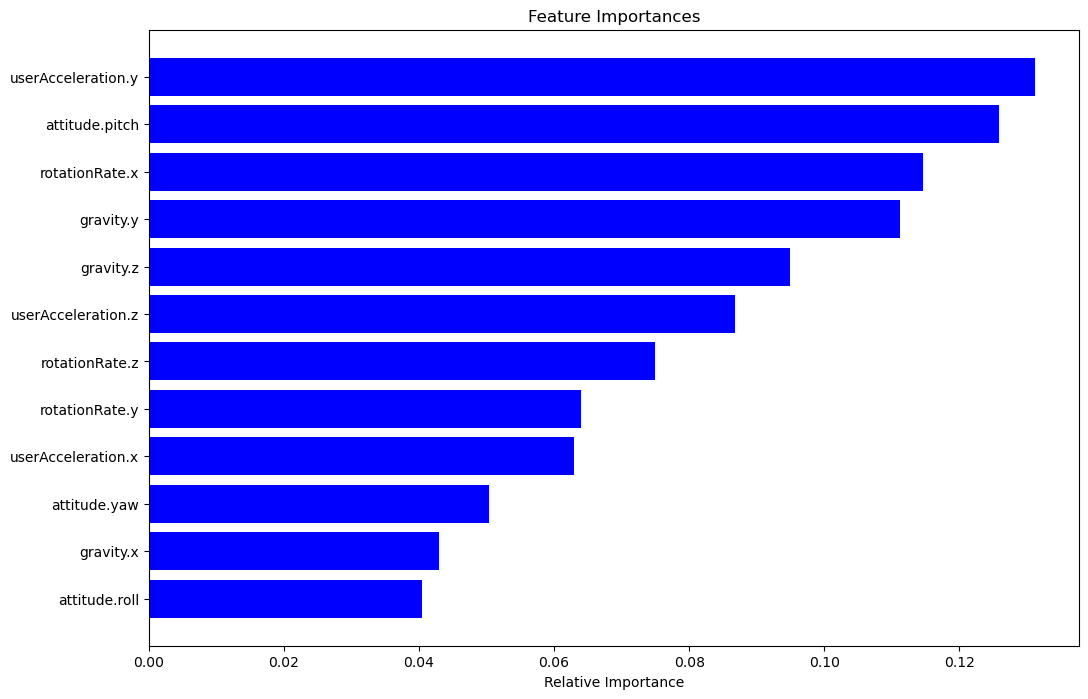

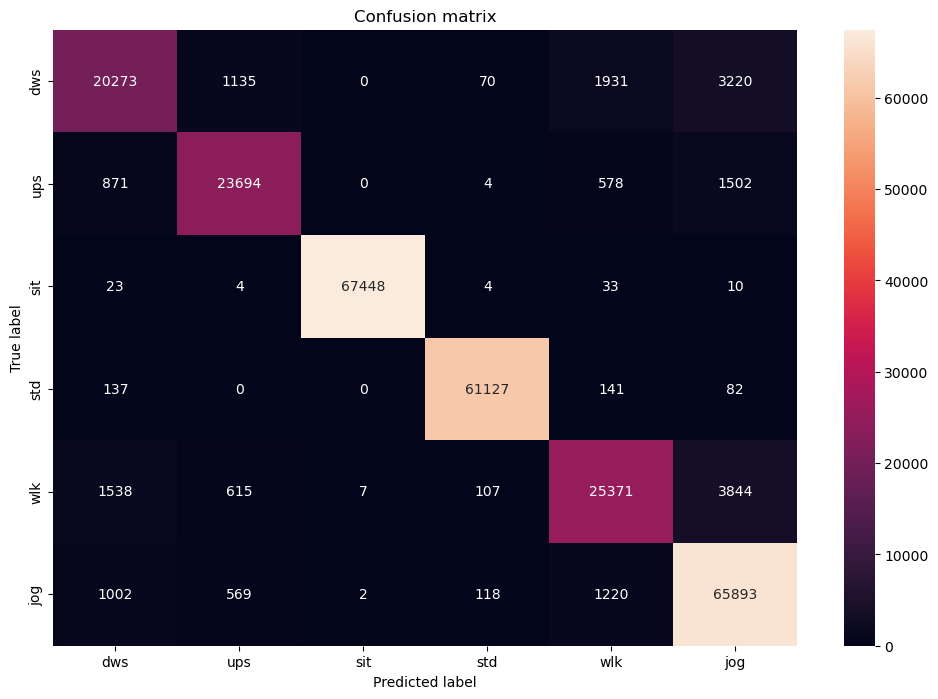

In [ ]:
# Pruebas con summary=False

# Random Forest
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [None]
}

pipeline_rf.preprocess(summary=False)
pipeline_rf.train_model(RandomForestClassifier(), param_grid_rf)
pipeline_rf.present_results()


Tenemos una precisión del 93% en el test.
El proceso de entrenamiento ha sido muy largo (310 minutos) puesto que el dataset es muy grande (1412865, 19).
El modelo funciona bien para detectar la actividad de sit, y std, (>99% de acierto), jog 96%, pero parece que tiene problemas en distinguir dws y wlk (76% y 81% respectivamente) de acierto.
Ha predicho 12% de las veces dws y wlk como jog con lo que parece que tiene problemas en reconocer la actividad de jog correctamente.

In [ ]:
# SVM
param_grid_svm = {
    'C': [1],
    'kernel': ['rbf']
}

pipeline_svm.preprocess(summary=False)
pipeline_svm.train_model(SVC(), param_grid_svm)
pipeline_svm.present_results()



KeyboardInterrupt: 

905minutos de entrenamiento. Interrumpimos la ejecución. Investigando en internet:
Support Vector Machines (SVMs) are slow to train due to their time and space complexity. The training process of SVMs has a time complexity of O(n^3) and a space complexity of O(n^2), where n is the size of the training dataset. This makes it computationally infeasible for very large datasets.
HAciendo cálculos parece que deberíamos ir a 73 años de entrenamiento basado en el tiempo de entrenamiento del modelo randomforest.



In [ ]:
# Creamos nuevas instancias de la clase DataPipeline para resetear resultados y configuraciones
pipeline_rf = DataPipeline(data_dir, subject_data_file, predictors, target)
pipeline_svm = DataPipeline(data_dir, subject_data_file, predictors, target)


#Summary = True
Con tal de reducir el tiempo de entrenamiento, en lugar de analizar dato a dato de cada grabación, vamos a tratar de extraer los features más relevantes de cada grabación, y analizar solo estas métricas resumen. De esta forma reduciremos el dataset de 1.4 millones de filas a 360 filas (24 individuos x 15 actividades).
Además, como el tiempo de entrenamiento se reducirá mucho, vamos a explorar el grid_search para estudiar qué parámetros dan mejor resultados en cada modelo.



Tamaño del DataFrame: (360, 41)
preprocesado completado
Mejores parámetros: {'max_depth': 50, 'n_estimators': 100}
entrenamiento completado
Accuracy en el conjunto de prueba: 0.9444444444444444
Accuracy en el conjunto de entrenamiento: 1.0


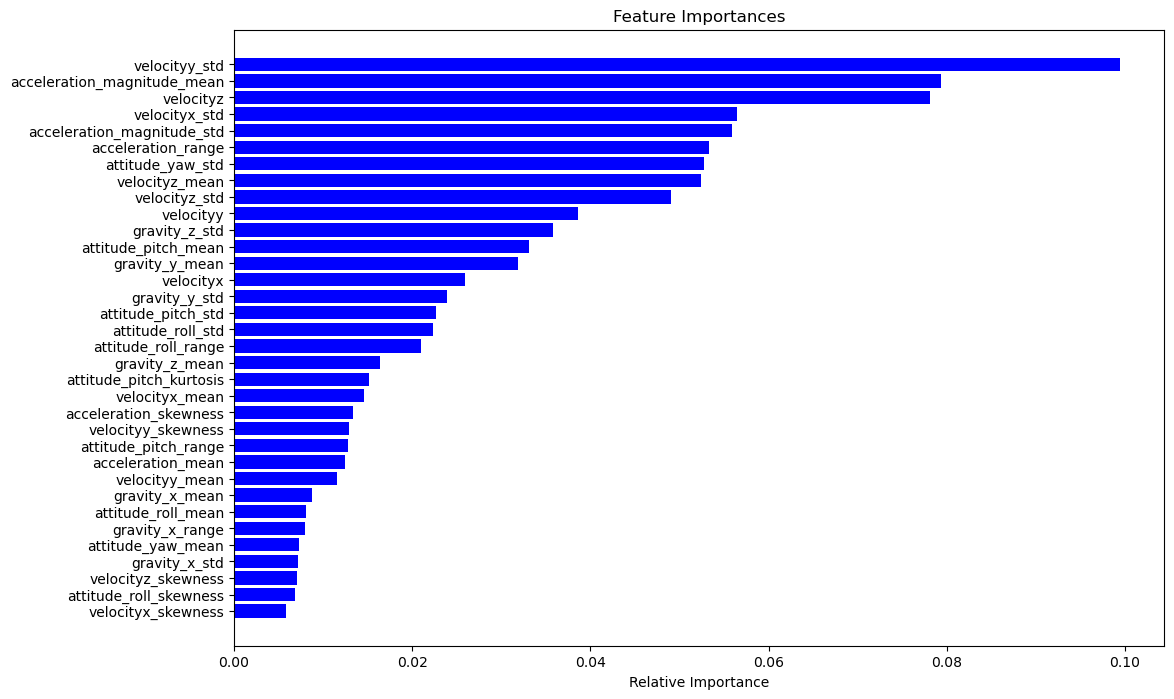

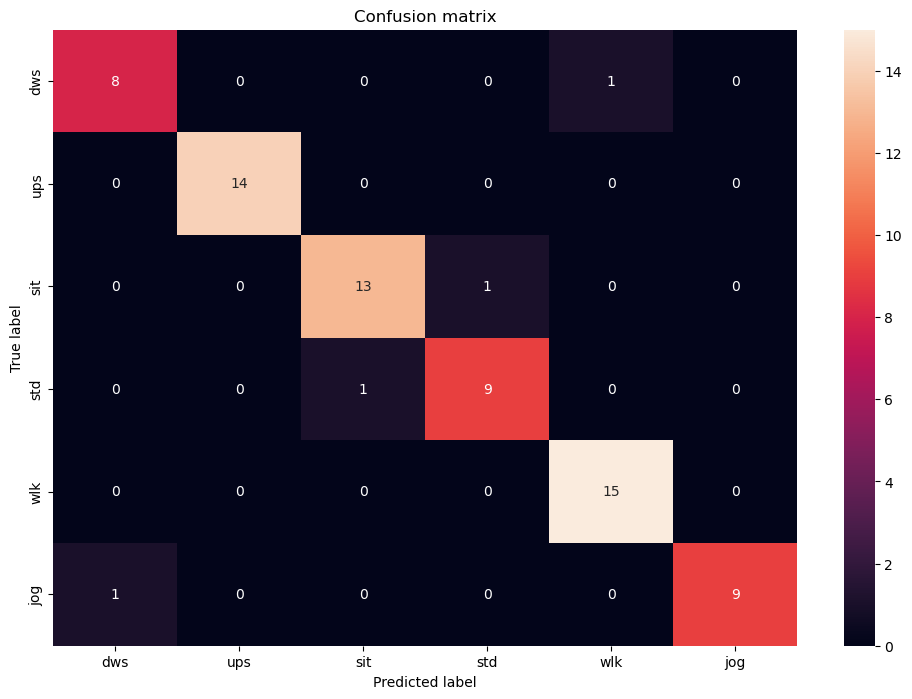

In [ ]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 1000, 10000],
    'max_depth': [None, 5, 10, 50]
}

pipeline_rf.preprocess(summary=True)
print("preprocesado completado")
pipeline_rf.train_model(RandomForestClassifier(), param_grid_rf)
print("entrenamiento completado")
pipeline_rf.present_results()

Parece que hemos mejorado algo la precisión de entrenamiento de 93,3% a 94,4%, aunque el dataset ahora es demasiado pequeño. Lo más importante es que hemos reducido mucho el tiempo de entrenamiento, de 310 minutos a 17 minutos. SI tuviéramos grabaciones de más individuos, este método nos ayudaría a analizar un dataset más grande.
En función de como quisiéramos aplicar la predicción, optaríamos por un modelo u otro. Es decir, si el objetivo es en tiempo real predecir la actividad, optaríamos por summary=False. Si lo que queremos es analziar una actividad pasada, podríamos optar por summary=True.


Tamaño del DataFrame: (360, 41)
Mejores parámetros: {'C': 10, 'kernel': 'rbf'}
Accuracy en el conjunto de prueba: 0.9027777777777778
Accuracy en el conjunto de entrenamiento: 0.9930555555555556


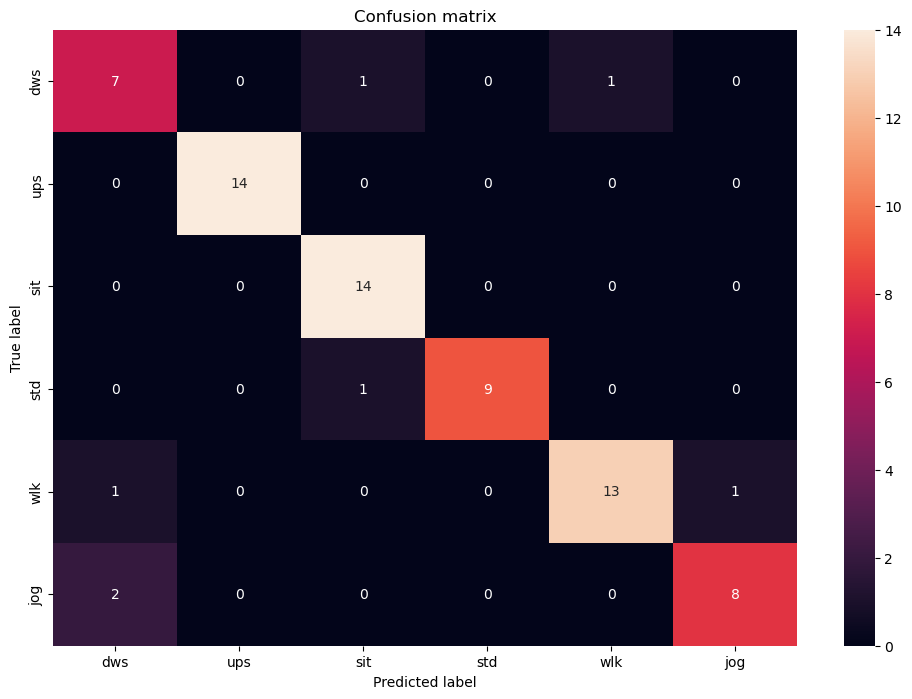

In [ ]:
# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

pipeline_svm.preprocess(summary=True)
pipeline_svm.train_model(SVC(), param_grid_svm)
pipeline_svm.present_results()

REsultados similares aunque parece que algo peor que con el modelo de random forest.

Como resumen, La clase DataPipeline realiza un conjunto de operaciones para cargar, preprocesar, entrenar, y evaluar un modelo de aprendizaje automático utilizando datos de series temporales de sensores de smartphone.

LA opción de summary=True reduce los tiempos de entrenamiento pero a cambio parece que el dataset es demasiado pequeño. Sería interesante comparar las curvas ROC de cada modelo para obtener una visión más completa del rendimiento de cada modelo.

Podríamos explorar la opción de incluir reducción de dimensionalidad con PCA, sobretodo para la versión de summary = False por el gran tamaño del dataset, revisar otros posibles features para la versión summary = True, y explorar otros modelos como gradient boosting, redes neuronales recurrentes o K-Nearest Neighbors (KNN).  
